# Исследование показов рекламы

## Цель
Проведение исследования показов рекламы для выявления условий влияющих на eCPM.

## Описание проекта
Мобильная игра зарабатывает на показе рекламы. Есть несколько форматов: int – полноэкранная реклама; banner – горизонтальный баннер, висит внизу экрана пока юзер играет; rv – видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы. Информация о каждом показе содержит доход от показа, формат показанной рекламы, рекламную сеть от которой был показ и др.  
eCPM – доход за 1000 показов рекламы.

### Сведения о данных

profile_id – id юзера  
event_json содержит данные о событии показа рекламы:  
    - ad_type – формат рекламы (int, banner или rv)  
    - placement – когда/где был показ рекламы в игре  
    - view_index – номер показа конкретного формата рекламы для юзера (не
поддерживается для баннеров)  
revenue – доход от конкретного показа рекламы (eCPM = revenue * 1000)  
ads_ltv – накапливающийся доход от рекламы, равен сумме всех revenue юзера  
network_name – рекламная сеть, от которой был показ  
Остальные столбцы должны быть интуитивно понятны  

## Порядок проведения исследования
1. Чтение данных представленных для анализа таблиц
2. Оценка данных
3. Предобработка данных
4. Анализ данных
    - Для каждого формата рекламы построим распределение средних eCPM-ов юзеров
    - Для каждого формата рекламы построим распределение eCPM-ов по городам, версиям ОС
    - Для каждого формата рекламы построим распределение доходов по городам, версиям ОС
    - Проверим гипотезы, при которых значения средних eCPM платформ одинаковые
    - Узнаем какой процент доходов содержит информацию о городе юзера
    - Узнаем зависит ли eCPM от времени дня
5. Общие выводы

Ссылка на задание: <https://drive.google.com/file/d/1NXeb5jWDn-pWkOMtOYLQimYK7wH88eJ8/view>  
Cсылка на файл.csv: <https://drive.google.com/drive/folders/1bjWlzyXV8ALcoxZYrdNQH6_MOm3nS3Pl?usp=sharing>


### Чтение данных представленной для анализа таблицы

In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as st
import json

In [2]:
# укажем путь к файлу
path = [
    'us events ad_revenue filtered 03.02-07.02.csv'
]
try:
    ad_revenue = pd.read_csv(path[0]) 
except:
    print('FileNotFoundError', path[0])   

In [3]:
display(ad_revenue.head(10))

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN
5,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:53,1644156953,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN
6,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:16:03,1644156963,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN
7,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:16:23,1644156983,2022-02-06 17:17:11,1644157031,cell,Verizon,US,NaN
8,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:16:33,1644156993,2022-02-06 17:17:11,1644157031,cell,Verizon,US,NaN
9,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:16:53,1644157013,2022-02-06 17:17:11,1644157031,cell,Verizon,US,NaN


**Вывод:**  
* Данные загружены корректно

### Оценка данных

In [4]:
def function(df):
    print ('------------- Краткая информация ------------')
    display(df.head())
    print ('*'*50)
    print ('------------- Сводные данные ------------')
    print(df.info())
    print ('*'*50)
    print ('------------- Количество пропусков ------------')
    print(df.isna().sum())
    print ('*'*50)
    print ('------------- Проверка наличия явных дубликатов ------------')
    if df.duplicated().sum() > 0:
        print ('Явных дубликатов - ', df.duplicated().sum())
    else:
        print ('Явных дубликатов нет')
    print ('*'*50)
    print ('------------- Количество уникальных значений ------------')
    for i in df.columns:
        print(f'в столбце {i} уникальных значений - {df[i].nunique()}')

In [5]:
function(ad_revenue)

------------- Краткая информация ------------


,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


**************************************************
------------- Сводные данные ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   profile_id               860065 non-null  object
 1   os_version               860079 non-null  object
 2   device_manufacturer      860079 non-null  object
 3   device_model             860079 non-null  object
 4   device_type              860079 non-null  object
 5   device_locale            860079 non-null  object
 6   event_name               860079 non-null  object
 7   event_json               860079 non-null  object
 8   event_datetime           860079 non-null  object
 9   event_timestamp          860079 non-null  int64 
 10  event_receive_datetime   860079 non-null  object
 11  event_receive_timestamp  860079 non-null  int64 
 12  connection_type          860079 non

In [6]:
# посмотрим что содержит event_json
json.loads(ad_revenue['event_json'][0])

{'ad_type': 'banner',
 'placement': '',
 'view_index': 1,
 'session_view_index': 0,
 'cur_ticks': 637795729492245130,
 'session_length': 705.8807,
 'revenue': 0.000510313,
 'ads_ltv': 0.487876676518837,
 'ecpm_sma': 0.511508107185364,
 'normalized_ecpm_sma': 0.511508107185364,
 'value': 0.000510313,
 'currency': 'USD',
 'ad_country_code': 'US',
 'network_name': 'Google AdMob',
 'ad_unit_id': '64c6b1114ea8c1cc',
 'ad_network_placement': 'ca-app-pub-7511632782617496/8825263691',
 'creativeId': 'CJ3XirfD5vUCFYPnKAUdG3MOYQ'}

**Вывод:**  
* Датафрейм содержит 16 столбцов и 860079 строк
* event_datetime, event_receive_datetime требуется привести к типу datatime
* profile_id имеет пропуски, количество менее 1% - удалим, не повлияет на исследование
* operator_name имеет пропуски, связанные с оператором wifi, заменим "заглушкой"
* city имеет пропуски более 37%, заменим "заглушкой"
* запишем данные из event_json в отдельные столбцы

### Предобработка данных

In [7]:
# Переведем тип данных в `datetime`
ad_revenue['event_datetime'] = pd.to_datetime(ad_revenue['event_datetime'])
ad_revenue['event_receive_datetime'] = pd.to_datetime(ad_revenue['event_receive_datetime'])

In [8]:
# удалим пропуски profile_id
ad_revenue = ad_revenue.dropna(subset = ['profile_id'])

In [9]:
# заменим пропуски значением 'nan'
ad_revenue['operator_name'] = ad_revenue['operator_name'].fillna('nan')
ad_revenue['city'] = ad_revenue['city'].fillna('nan')

In [10]:
# представим данные в json формате
ad_revenue['event_json'] = ad_revenue['event_json'].apply(json.loads)

In [11]:
# плучим данные из event_json и занесем их в столбцы отдельно
def ad_type(name):
    a = name['event_json']['ad_type']
    return a
def placement(name):
    a = name['event_json']['placement']
    return a
def view_index(name):
    a = name['event_json']['view_index']
    return a
def eCPM(name):
    a = name['event_json']['revenue'] / 1000
    return a
def ads_ltv(name):
    a = name['event_json']['ads_ltv']
    return a
def network_name(name):
    a = name['event_json']['network_name']
    return a

In [12]:
ad_revenue['ad_type'] = ad_revenue.apply(ad_type, axis=1)
ad_revenue['placement'] = ad_revenue.apply(placement, axis=1)
ad_revenue['view_index'] = ad_revenue.apply(view_index, axis=1)
ad_revenue['eCPM'] = ad_revenue.apply(eCPM, axis=1)
ad_revenue['ads_ltv'] = ad_revenue.apply(ads_ltv, axis=1)
ad_revenue['network_name'] = ad_revenue.apply(network_name, axis=1)

In [13]:
ad_revenue.tail()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,...,connection_type,operator_name,country_iso_code,city,ad_type,placement,view_index,eCPM,ads_ltv,network_name
860074,JLSQY2nx1NQ,12,Samsung,Galaxy S21 Ultra 5G,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-03 08:29:27,1643866167,...,wifi,Verizon,US,Elmira,banner,,1,1.997224e-08,1.007506,APPLOVIN_EXCHANGE
860075,JLKWwju79CA,12,Samsung,SM-G991U,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-03 02:12:51,1643843571,...,cell,Verizon,US,Cherry Hill,banner,,1,6.740355e-06,0.277541,Google AdMob
860076,JLKWwju79CA,12,Samsung,SM-G991U,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-03 02:13:06,1643843586,...,cell,Verizon,US,Cherry Hill,banner,,1,2.780058e-06,0.280321,Google AdMob
860077,JLKWwju79CA,12,Samsung,SM-G991U,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-03 02:13:17,1643843597,...,cell,Verizon,US,Cherry Hill,banner,,1,2.780058e-06,0.283101,Google AdMob
860078,JLKWwju79CA,12,Samsung,SM-G991U,phone,en_US,c_ad_revenue,"{'ad_type': 'banner', 'placement': '', 'view_i...",2022-02-03 03:11:44,1643847104,...,cell,Verizon,US,Cherry Hill,banner,,1,2.780058e-06,0.285881,Google AdMob


**Вывод:**  
* Тип данных приведен в соответствие
* Пропуски удалены или заменены "заглушкой"
* Данные из event_json извлечены и записаны отдельно

### Анализ данных

#### Для каждого формата рекламы построим распределение средних eCPM-ов юзеров

In [14]:
ad_revenue.pivot_table(index='ad_type', values= 'eCPM' , aggfunc=('count', 'sum', 'mean', 'median', np.var, np.std))

,count,mean,median,std,sum,var
ad_type,,,,,,
banner,815973,7.441164e-07,4.941960e-07,0.000001,0.607179,1.963590e-12
int,37610,3.621081e-05,2.139886e-05,0.000048,1.361889,2.322135e-09
rv,6482,6.505117e-05,3.146896e-05,0.000076,0.421662,5.764893e-09


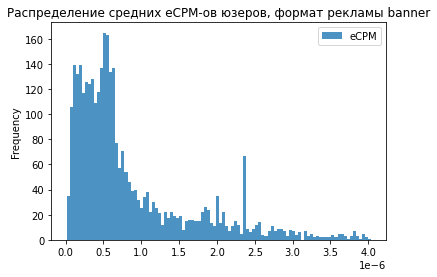

Среднее значение средних eCPM - 7.441164488220084e-07
Медианное значение средних eCPM - 4.941960000000001e-07
95% значений средних eCPM до уровня - 4.061165497953411e-06 , остальные считаем выбросами


In [15]:
ad_revenue.query('ad_type == "banner"').pivot_table(index = 'profile_id', values='eCPM', aggfunc= 'mean').reset_index().query('eCPM > 0 & eCPM <= 4.061165497953411e-06').plot(kind = 'hist', bins = 100, alpha = 0.8, title = 'Распределение средних eCPM-ов юзеров, формат рекламы banner')
plt.show()

print('Среднее значение средних eCPM -', ad_revenue.query('ad_type == "banner"')['eCPM'].mean())
print('Медианное значение средних eCPM -', ad_revenue.query('ad_type == "banner"')['eCPM'].median())
print('95% значений средних eCPM до уровня -', 
      np.percentile(ad_revenue.query('ad_type == "banner"').pivot_table(index = 'profile_id', values='eCPM', aggfunc= 'mean')['eCPM'], [95])[0],
      ', остальные считаем выбросами')

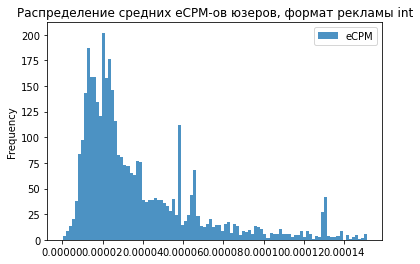

Среднее значение средних eCPM - 3.6210812668218534e-05
Медианное значение средних eCPM - 2.1398855324074097e-05
95% значений средних eCPM до уровня - 0.00015145065643310549 , остальные считаем выбросами


In [16]:
ad_revenue.query('ad_type == "int"').pivot_table(index = 'profile_id', values='eCPM', aggfunc= 'mean').reset_index().query('eCPM > 0 & eCPM <= 0.00015145065643310549').plot(kind = 'hist', bins = 100, alpha = 0.8, title = 'Распределение средних eCPM-ов юзеров, формат рекламы int')
plt.show()

print('Среднее значение средних eCPM -', ad_revenue.query('ad_type == "int"')['eCPM'].mean())
print('Медианное значение средних eCPM -', ad_revenue.query('ad_type == "int"')['eCPM'].median())
print('95% значений средних eCPM до уровня -', 
      np.percentile(ad_revenue.query('ad_type == "int"').pivot_table(index = 'profile_id', values='eCPM', aggfunc= 'mean')['eCPM'], [95])[0],
      ', остальные считаем выбросами')

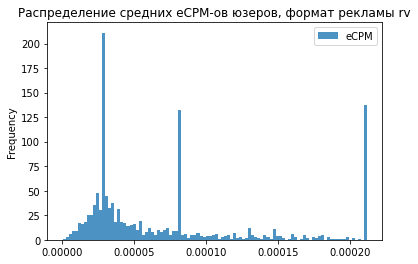

Среднее значение средних eCPM - 6.5051165091083e-05
Медианное значение средних eCPM - 3.14689611940299e-05
95% значений средних eCPM до уровня - 0.0002117 , остальные считаем выбросами


In [17]:
ad_revenue.query('ad_type == "rv"').pivot_table(index = 'profile_id', values='eCPM', aggfunc= 'mean').reset_index().query('eCPM > 0 & eCPM <= 0.0002117').plot(kind = 'hist', bins = 100, alpha = 0.8, title = 'Распределение средних eCPM-ов юзеров, формат рекламы rv')
plt.show()

print('Среднее значение средних eCPM -', ad_revenue.query('ad_type == "rv"')['eCPM'].mean())
print('Медианное значение средних eCPM -', ad_revenue.query('ad_type == "rv"')['eCPM'].median())
print('95% значений средних eCPM до уровня -', 
      np.percentile(ad_revenue.query('ad_type == "rv"').pivot_table(index = 'profile_id', values='eCPM', aggfunc= 'mean')['eCPM'], [95])[0],
      ', остальные считаем выбросами')

**Вывод:**  
* Распределение средних eCPM по юзерам стремится к нормальному смещенному влево

#### Для каждого формата рекламы построим распределение eCPM-ов по городам, версиям ОС

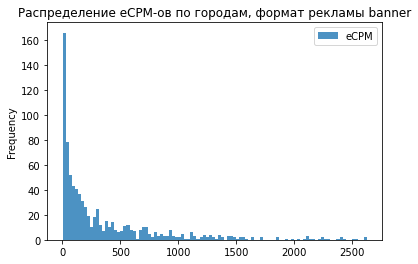

95% значений eCPM до уровня - 2631.6 , остальные считаем выбросами


In [18]:
ad_revenue.query('ad_type == "banner"').pivot_table(index = 'city', values='eCPM', aggfunc= 'count').reset_index().query('eCPM > 0 & eCPM <= 2631.6').plot(kind = 'hist', bins = 100, alpha = 0.8, title ='Распределение eCPM-ов по городам, формат рекламы banner')
plt.show()

print('95% значений eCPM до уровня -', 
      round(np.percentile(ad_revenue.query('ad_type == "banner"').pivot_table(index = 'city', values='eCPM', aggfunc= 'count')['eCPM'], [95])[0], 5),
      ', остальные считаем выбросами')

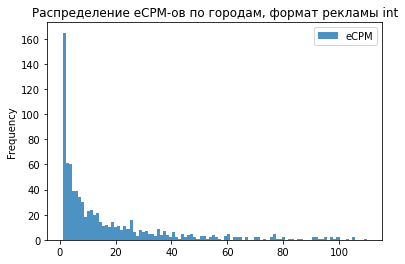

95% значений eCPM до уровня - 111.1 , остальные считаем выбросами


In [19]:
ad_revenue.query('ad_type == "int"').pivot_table(index = 'city', values='eCPM', aggfunc= 'count').reset_index().query('eCPM > 0 & eCPM <= 111.1').plot(kind = 'hist', bins = 100, alpha = 0.8, title = 'Распределение eCPM-ов по городам, формат рекламы int')
plt.show()

print('95% значений eCPM до уровня -', 
      round(np.percentile(ad_revenue.query('ad_type == "int"').pivot_table(index = 'city', values='eCPM', aggfunc= 'count')['eCPM'], [95])[0], 5),
      ', остальные считаем выбросами')

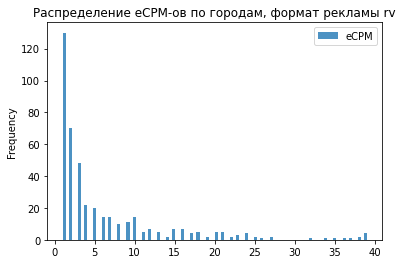

95% значений eCPM до уровня - 39.3 , остальные считаем выбросами


In [20]:
ad_revenue.query('ad_type == "rv"').pivot_table(index = 'city', values='eCPM', aggfunc= 'count').reset_index().query('eCPM > 0 & eCPM <= 39.3').plot(kind = 'hist', bins = 100, alpha = 0.8, title = 'Распределение eCPM-ов по городам, формат рекламы rv')
plt.show()

print('95% значений eCPM до уровня -', 
      round(np.percentile(ad_revenue.query('ad_type == "rv"').pivot_table(index = 'city', values='eCPM', aggfunc= 'count')['eCPM'], [95])[0], 5),
      ', остальные считаем выбросами')

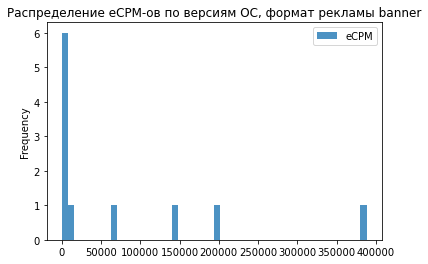

In [21]:
ad_revenue.query('ad_type == "banner"').pivot_table(index = 'os_version', values='eCPM', aggfunc= 'count').reset_index().plot(kind = 'hist', bins = 50, alpha = 0.8, title = 'Распределение eCPM-ов по версиям ОС, формат рекламы banner')
plt.show()

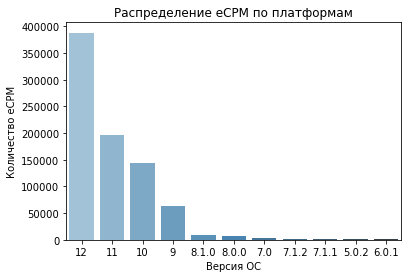

In [22]:
sns.barplot(data = ad_revenue.query('ad_type == "banner"').pivot_table(index = 'os_version', values='eCPM', aggfunc= 'count').reset_index().sort_values(by = 'eCPM', ascending = False),
             x = 'os_version', y = 'eCPM', palette="Blues_d").set(title = 'Распределение eCPM по платформам', xlabel = 'Версия ОС', ylabel = 'Количество eCPM')

plt.show()

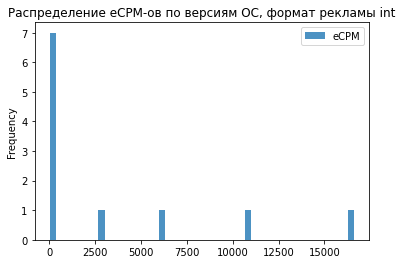

In [23]:
ad_revenue.query('ad_type == "int"').pivot_table(index = 'os_version', values='eCPM', aggfunc= 'count').reset_index().plot(kind = 'hist', bins = 50, alpha = 0.8, title = 'Распределение eCPM-ов по версиям ОС, формат рекламы int')
plt.show()

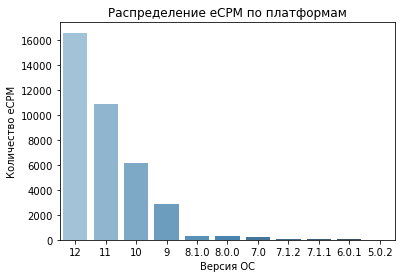

In [24]:
sns.barplot(data = ad_revenue.query('ad_type == "int"').pivot_table(index = 'os_version', values='eCPM', aggfunc= 'count').reset_index().sort_values(by = 'eCPM', ascending = False),
             x = 'os_version', y = 'eCPM', palette="Blues_d").set(title = 'Распределение eCPM по платформам', xlabel = 'Версия ОС', ylabel = 'Количество eCPM')

plt.show()

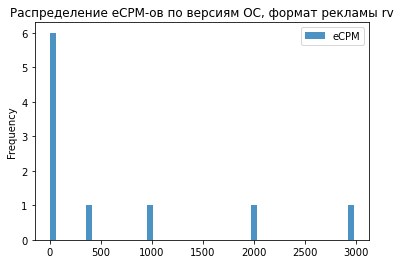

In [25]:
ad_revenue.query('ad_type == "rv"').pivot_table(index = 'os_version', values='eCPM', aggfunc= 'count').reset_index().plot(kind = 'hist', bins = 50, alpha = 0.8, title = 'Распределение eCPM-ов по версиям ОС, формат рекламы rv')
plt.show()

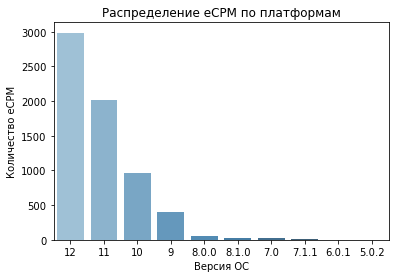

In [26]:
sns.barplot(data = ad_revenue.query('ad_type == "rv"').pivot_table(index = 'os_version', values='eCPM', aggfunc= 'count').reset_index().sort_values(by = 'eCPM', ascending = False),
             x = 'os_version', y = 'eCPM', palette="Blues_d").set(title = 'Распределение eCPM по платформам', xlabel = 'Версия ОС', ylabel = 'Количество eCPM')

plt.show()

In [27]:
for i in list(ad_revenue['os_version'].unique()):
    if i not in list(ad_revenue.query('ad_type == "rv"')['os_version'].unique()):
        print('Дохода от рекламы rv в ОС версии',i, 'нет')

Дохода от рекламы rv в ОС версии 7.1.2 нет


**Вывод**
* Распределения eCPM-ов по городам и версиям ОС стремятся к нормальному, хотя и смещены влево
* eCPM от размещения рекламы "rv" на ОС '7.1.2' нет

#### Для каждого формата рекламы построим распределение доходов по городам, версиям ОС

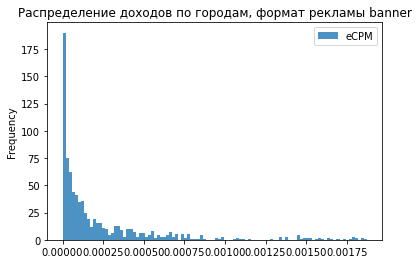

95% значений eCPM до уровня - 0.0019 , остальные считаем выбросами


In [28]:
ad_revenue.query('ad_type == "banner"').pivot_table(index = 'city', values='eCPM', aggfunc= 'sum').reset_index().query('eCPM > 0 & eCPM <= 0.0019').plot(kind = 'hist', bins = 100, alpha = 0.8, title = 'Распределение доходов по городам, формат рекламы banner')
plt.show()

print('95% значений eCPM до уровня -', 
      round(np.percentile(ad_revenue.query('ad_type == "banner"').pivot_table(index = 'city', values='eCPM', aggfunc= 'sum')['eCPM'], [95])[0], 5),
      ', остальные считаем выбросами')

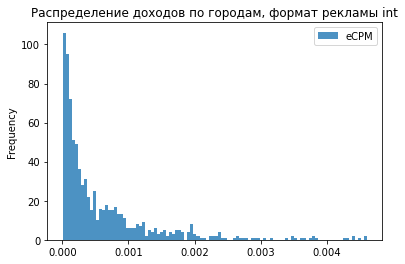

95% значений eCPM до уровня - 0.00461 , остальные считаем выбросами


In [29]:
ad_revenue.query('ad_type == "int"').pivot_table(index = 'city', values='eCPM', aggfunc= 'sum').reset_index().query('eCPM > 0 & eCPM <= 0.00461').plot(kind = 'hist', bins = 100, alpha = 0.8, title = 'Распределение доходов по городам, формат рекламы int')
plt.show()

print('95% значений eCPM до уровня -', 
      round(np.percentile(ad_revenue.query('ad_type == "int"').pivot_table(index = 'city', values='eCPM', aggfunc= 'sum')['eCPM'], [95])[0], 5),
      ', остальные считаем выбросами')

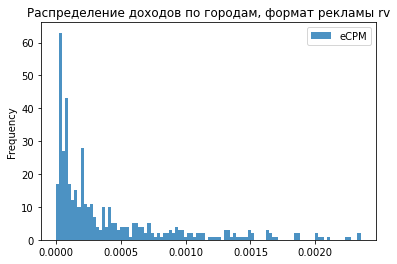

95% значений eCPM до уровня - 0.00237 , остальные считаем выбросами


In [30]:
ad_revenue.query('ad_type == "rv"').pivot_table(index = 'city', values='eCPM', aggfunc= 'sum').reset_index().query('eCPM > 0 & eCPM <= 0.00237').plot(kind = 'hist', bins = 100, alpha = 0.8, title = 'Распределение доходов по городам, формат рекламы rv')
plt.show()

print('95% значений eCPM до уровня -', 
      round(np.percentile(ad_revenue.query('ad_type == "rv"').pivot_table(index = 'city', values='eCPM', aggfunc= 'sum')['eCPM'], [95])[0], 5),
      ', остальные считаем выбросами')

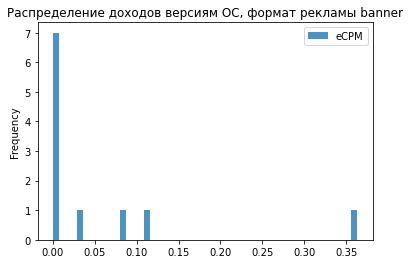

In [31]:
ad_revenue.query('ad_type == "banner"').pivot_table(index = 'os_version', values='eCPM', aggfunc= 'sum').reset_index().plot(kind = 'hist', bins = 50, alpha = 0.8, title ='Распределение доходов версиям ОС, формат рекламы banner')
plt.show()

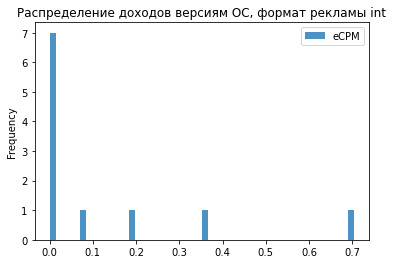

In [32]:
ad_revenue.query('ad_type == "int"').pivot_table(index = 'os_version', values='eCPM', aggfunc= 'sum').reset_index().plot(kind = 'hist', bins = 50, alpha = 0.8, title ='Распределение доходов версиям ОС, формат рекламы int')
plt.show()

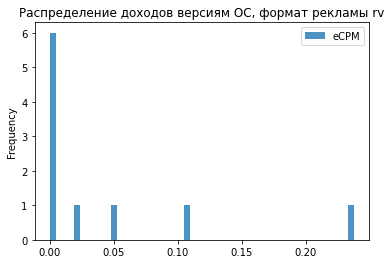

In [33]:
ad_revenue.query('ad_type == "rv"').pivot_table(index = 'os_version', values='eCPM', aggfunc= 'sum').reset_index().plot(kind = 'hist', bins = 50, alpha = 0.8, title = 'Распределение доходов версиям ОС, формат рекламы rv')
plt.show()

**Вывод:**
* Распределения доходов по городам и версиям ОС стремятся к нормальному, хотя и смещены влево
* Доходов от размещения рекламы "rv" на ОС '7.1.2' нет

**Проверим, значение средних eCPM платформ одинаковые:**  
H0: Средний eCPM пользователей разных рекламных платформ banner и int одинаковый.  
H1: Средний eCPM пользователей разных рекламных платформ banner и int различается.

In [34]:
print('Средний eCPM разных рекламных платформ banner', ad_revenue.query('ad_type == "banner"')['eCPM'].mean())
print('Средний eCPM разных рекламных платформ int', ad_revenue.query('ad_type == "int"')['eCPM'].mean())
print()

results = st.ttest_ind(
    ad_revenue.query('ad_type == "banner"')['eCPM'], 
    ad_revenue.query('ad_type == "int"')['eCPM'], 
    equal_var=False)

alpha = 0.05
print('p-значение:', round(results.pvalue, 5))

if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу')
else:
    print('Опровергнуть нулевую гипотезу нельзя')

Средний eCPM разных рекламных платформ banner 7.441164488220084e-07
Средний eCPM разных рекламных платформ int 3.6210812668218534e-05

p-значение: 0.0
Принимаем альтернативную гипотезу


**Проверим, значение средних eCPM платформ одинаковые:**  
H0: Средний eCPM пользователей разных рекламных платформ banner и rv одинаковый.  
H1: Средний eCPM пользователей разных рекламных платформ banner и rv различается.

In [35]:
print('Средний eCPM разных рекламных платформ banner', ad_revenue.query('ad_type == "banner"')['eCPM'].mean())
print('Средний eCPM разных рекламных платформ rv', ad_revenue.query('ad_type == "rv"')['eCPM'].mean())
print()

results = st.ttest_ind(
    ad_revenue.query('ad_type == "banner"')['eCPM'], 
    ad_revenue.query('ad_type == "rv"')['eCPM'], 
    equal_var=False)

alpha = 0.05
print('p-значение:', round(results.pvalue, 5))

if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу')
else:
    print('Опровергнуть нулевую гипотезу нельзя')

Средний eCPM разных рекламных платформ banner 7.441164488220084e-07
Средний eCPM разных рекламных платформ rv 6.5051165091083e-05

p-значение: 0.0
Принимаем альтернативную гипотезу


**Проверим, значение средних eCPM платформ одинаковые:**  
H0: Средний eCPM пользователей разных рекламных платформ int и rv одинаковый.  
H1: Средний eCPM пользователей разных рекламных платформ int и rv различается.

In [36]:
print('Средний eCPM разных рекламных платформ int', ad_revenue.query('ad_type == "int"')['eCPM'].mean())
print('Средний eCPM разных рекламных платформ rv', ad_revenue.query('ad_type == "rv"')['eCPM'].mean())
print()

results = st.ttest_ind(
    ad_revenue.query('ad_type == "int"')['eCPM'], 
    ad_revenue.query('ad_type == "rv"')['eCPM'], 
    equal_var=False)

alpha = 0.05
print('p-значение:', round(results.pvalue, 5))

if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу')
else:
    print('Опровергнуть нулевую гипотезу нельзя')

Средний eCPM разных рекламных платформ int 3.6210812668218534e-05
Средний eCPM разных рекламных платформ rv 6.5051165091083e-05

p-значение: 0.0
Принимаем альтернативную гипотезу


**Вывод:** 
* Средние значения eCPM разных рекламных платформ при уровне статичтической значимости равной 0.05 отличаются.

#### Узнаем какой процент доходов содержит информацию о городе юзера

In [37]:
print('Информацию о городе юзера содержит -', round(ad_revenue.query('city != "nan"')['eCPM'].sum() / ad_revenue['eCPM'].sum() * 100, 2), '% доходов')

Информацию о городе юзера содержит - 63.58 % доходов


#### Узнаем зависит ли eCPM от времени дня

In [38]:
ad_revenue['event_receive_datetime_hour'] = pd.to_datetime(ad_revenue['event_receive_datetime']).dt.hour

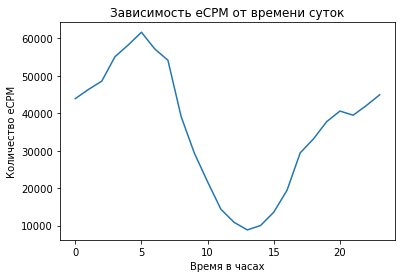

In [39]:
ad_revenue_hour = ad_revenue.pivot_table(index = 'event_receive_datetime_hour', values='eCPM', aggfunc= 'count').reset_index()
sns.lineplot(data = ad_revenue_hour, x = 'event_receive_datetime_hour', y = 'eCPM', palette="Blues_d").set(title = 'Зависимость eCPM от времени суток', xlabel = 'Время в часах', ylabel = 'Количество eCPM')

plt.show()

### Вывод:
- Осуществлено чтение  и загрузка данных из файла, их оценка и предобработка
- Для каждого формата рекламы построим распределение средних eCPM-ов юзеров, распределение стремится к нормальному, но смещено влево. Медианное значение eCPM для разных форматов реклам = 
        - banner - 4.94e-07
        - int - 2.14e-05
        - rv - 3.15e-05
- Для каждого формата рекламы построим распределение eCPM-ов по городам, версиям ОС - распределения стремятся к нормальному, но смещены влево. Дохода от рекламы rv в ОС версии 7.1.2 нет.
- Для каждого формата рекламы построим распределение доходов по городам, версиям ОС - распределения стремятся к нормальному, но смещены влево.
- Осуществлена проверка гипотез равенства средних eCPM разных рекламных платформ, в хоже которой выявлено, что средние eCPM при уровне статичтической значимость равной 0.05 имеют статистические различия.
- Информацию о городе юзера содержит - 63.58 % доходов
- Значение eCPM зависит от времени дня, при этом зависимость синусоидальная - в 5 часов пик, в 13 часов спад
- Таким образом на покаатель eCPM влияет как форматов реклам, город и версиям ОС, а также время показа.